In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, identity
import cv2
from IPython.display import clear_output
import time
from tqdm import tqdm

In [0]:
def box_house(posx, posy, x, y):
    return (posx < x < posx + 18 and posy < y < posy + 18)


def L_house(posx, posy, x, y):
    if posx < x and x < posx + 18 and posy < y and y < posy + 78:
        return True

    posx = posx + 12

    return (posx < x and x < posx + 12 and posy < y and y < posy + 18)


def L_flipped_house(posx, posy, x, y):
    if posx < x and x < posx + 18 and posy < y and y < posy + 78:
        return True

    posx = posx - 12
    posy = posy + 60

    return (posx < x and x < posx + 13 and posy < y and y < posy + 18)


def check_boxes(x, y):
    boxes = [(69, 111), (69, 264),
             (138, 12), (138, 165),
             (192, 111), (192, 264),
             (261, 12), (261, 165)]
    for box in boxes:
        if box_house(box[0], box[1], x, y):
            return True
    return False


def check_L(x, y):
    L_houses = [(69, 12), (69, 165),
                (192, 12), (192, 165)]
    for house in L_houses:
        if L_house(house[0], house[1], x, y):
            return True
    return False


def check_L_flipped(x, y):
    L_flipped_houses = [(138, 51), (138, 204),
                        (261, 51), (261, 204)]
    for house in L_flipped_houses:
        if L_flipped_house(house[0], house[1], x, y):
            return True
    return False


def check_houses(x, y):
    return check_boxes(x, y) or check_L(x, y) or check_L_flipped(x, y)


def check_edge_cond(x, y, n):
    x = (x / n) * n
    y = (y / n) * n
    return check_houses(x, y) or (x > n - 1 or y > n - 1 or y == 0 or x < 0)


def crossSchema(eps=1e-6, history=True):
    n = 300
    k = 0.5
    lambda1 = 1.0
    lambda2 = 0.0
    steps = 100000

    N = n ** 2
    h = 1 / n
    tau = h ** 2 / (4 * k)

    x = np.zeros((N, 1))
    for i in range(n):
        x[i:n, 0] = 1

    A = lil_matrix((N, N))
    b = np.zeros(N)

    dx = [1, -1, 0, 0]
    dy = [0, 0, 1, -1]
    u0coeff = 1 - 4 * (tau * k) / (h ** 2)
    coeffs = [tau * (k / (h ** 2) - lambda1 / (2 * h)),
              tau * (k / (h ** 2) + lambda1 / (2 * h)),
              tau * (k / (h ** 2) - lambda2 / (2 * h)),
              tau * (k / (h ** 2) + lambda2 / (2 * h))]

    for r in range(n):
        for c in range(n):
            ind = r * n + c
            A[ind, ind] = u0coeff

            for j in range(0, 4):
                x1 = c + dx[j]
                y1 = r + dy[j]
                coeff = coeffs[j]

                if x1 == 0:
                    b[ind] -= coeff
                elif check_edge_cond(x1, y1, n):
                    A[ind, ind] += coeff
                else:
                    A[ind, y1 * n + x1] += coeff

    A = csr_matrix(A)
    b = b.reshape(N, -1)
    error = 1
    i = 0
    with tqdm(total=steps) as pbar:
        for i in range(steps):
            x_new = A * x + b
            error = np.max(np.abs(x_new - x))
            if error < eps:
                break
            x = x_new
            i += 1
            pbar.update(1)

    return x.reshape((300, 300)), error


100%|██████████| 100000/100000 [01:29<00:00, 1122.90it/s]


Final error: 5.3631953591537496e-06, Duration: 93.20338559150696s


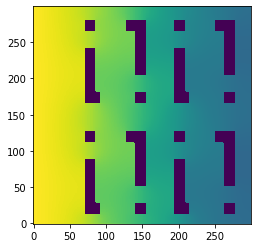

In [7]:
start = time.time()
x_res, error = crossSchema()
end = time.time()
print(f'Final error: {error}, Duration: {end - start}s')
plt.imshow(1 - x_res)
plt.gca().invert_yaxis()
plt.show()